# Podstawy Przetwarzania Dużych Zbiorów Danych

Grupa IBD4 Poniedziałki 8:30

Łukasz Moskwa 247739

Artur Szewczykowski 252546


In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
merged_covid_df = pd.read_csv("../wyniki/final_final.csv")

In [3]:
display(merged_covid_df) #wrzucone dla wygody, można usunąc przed odpowiedzią

,Country_name,3_letter_code,population_urban,date,Total_confirmed_cases,Total_new_vacinations,New_persons_fully_vaccinated,Total_tested,Rank,Capital,...,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage,Year,Value,Inflation,Unemployment,Crime Rate
0,Colombia,COL,40827302.0,2021-03-14,2728,54597.0,6306.0,30968,28,Bogota,...,20905254,1141748,45.4339,1.0069,0.65,1960.0,4.040948e+09,NaN,NaN,NaN
1,Colombia,COL,40827302.0,2021-03-14,2728,54597.0,6306.0,30968,28,Bogota,...,20905254,1141748,45.4339,1.0069,0.65,1961.0,4.552914e+09,NaN,NaN,NaN
2,Colombia,COL,40827302.0,2021-03-14,2728,54597.0,6306.0,30968,28,Bogota,...,20905254,1141748,45.4339,1.0069,0.65,1962.0,4.968604e+09,NaN,NaN,NaN
3,Colombia,COL,40827302.0,2021-03-14,2728,54597.0,6306.0,30968,28,Bogota,...,20905254,1141748,45.4339,1.0069,0.65,1963.0,4.838841e+09,NaN,NaN,NaN
4,Colombia,COL,40827302.0,2021-03-14,2728,54597.0,6306.0,30968,28,Bogota,...,20905254,1141748,45.4339,1.0069,0.65,1964.0,5.992169e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971186,Togo,TGO,3414638.0,2022-03-11,2,9102.0,0.0,1056,100,Lomé,...,2197383,56785,155.8281,1.0236,0.11,2012.0,3.866617e+09,2.577,2.030,2.030
1971187,Togo,TGO,3414638.0,2022-03-11,2,9102.0,0.0,1056,100,Lomé,...,2197383,56785,155.8281,1.0236,0.11,2013.0,4.080929e+09,1.825,2.085,2.085
1971188,Togo,TGO,3414638.0,2022-03-11,2,9102.0,0.0,1056,100,Lomé,...,2197383,56785,155.8281,1.0236,0.11,2014.0,4.482880e+09,0.191,2.142,2.142
1971189,Togo,TGO,3414638.0,2022-03-11,2,9102.0,0.0,1056,100,Lomé,...,2197383,56785,155.8281,1.0236,0.11,2015.0,4.087628e+09,1.785,2.204,2.204


Część 1 (poziom podstawowy) - wykresy pudełkowe

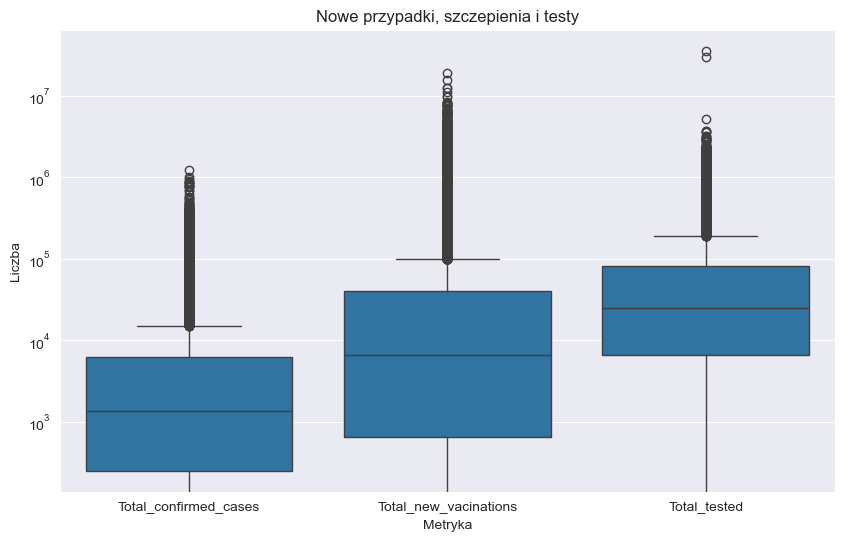

In [12]:
#1.1-1.3 nowe zachorowania, śmierci i szczepienia

# Usunięcie duplikatów - każda data dla danego kraju pojawia się tylko raz
df_filtered = merged_covid_df.drop_duplicates(subset=["Country_name", "date"])

# Konwersja do formatu long (dla jednego wykresu)
df_melted = df_filtered.melt(
    value_vars=["Total_confirmed_cases", "Total_new_vacinations", "Total_tested"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="Metric", y="Cases")

# Skala logarytmiczna
plt.yscale("log")

# Opisy
plt.title("Liczba nowych przypadków, szczepienień i testów")

# Pokaż wykres
plt.show()


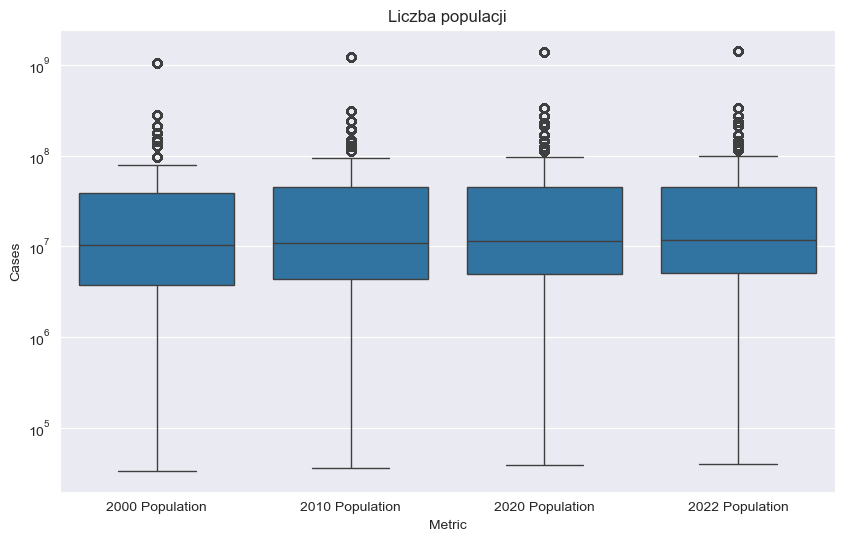

In [29]:
#1.4 populacja i 3 dodatkowe kolumny

# Konwersja do formatu long (dla jednego wykresu)
df_melted = df_filtered.melt(
    value_vars=["2000 Population", "2010 Population", "2020 Population", "2022 Population"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="Metric", y="Cases")

# Skala logarytmiczna
plt.yscale("log")

# Opisy
plt.title("Liczba populacji")

# Pokaż wykres
plt.show()

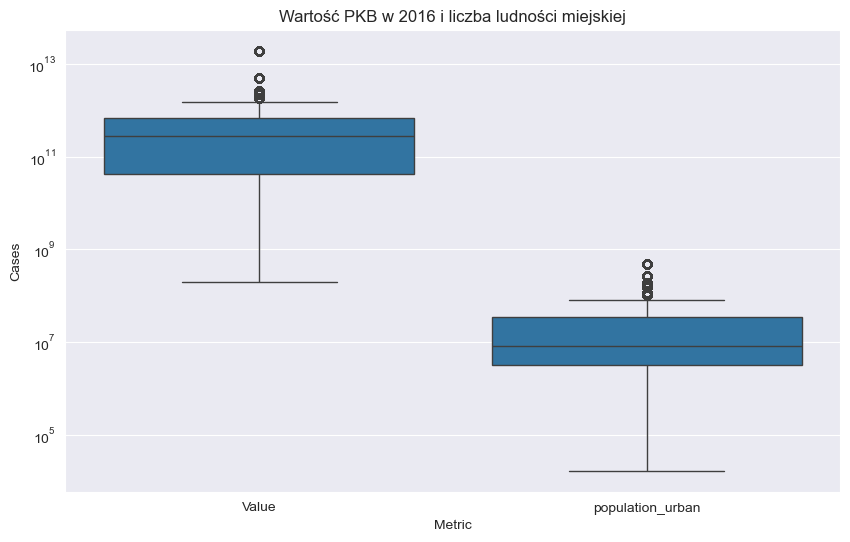

In [31]:
#1.5 PKB i 1 dodatkowa kolumna
df_filtered2 = (
    merged_covid_df[merged_covid_df["Year"] == 2016.0] #nie wiem co z tym bo niby na dużo przed pandemią, ale w danych z wikampa GPD kończyło się na 2016 xd
    .drop_duplicates(subset=["Country_name", "date"])
)

# Konwersja do formatu long (dla jednego wykresu)
df_melted = df_filtered2.melt(
    value_vars=["Value", "population_urban"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="Metric", y="Cases")

# Skala logarytmiczna
plt.yscale("log")

# Opisy
plt.title("Wartość PKB w 2016 i liczba ludności miejskiej")

# Pokaż wykres
plt.show()

TODO: zmienić na rok 2020/2021 albo 2022 jak będzie nowy plik z poziomu1

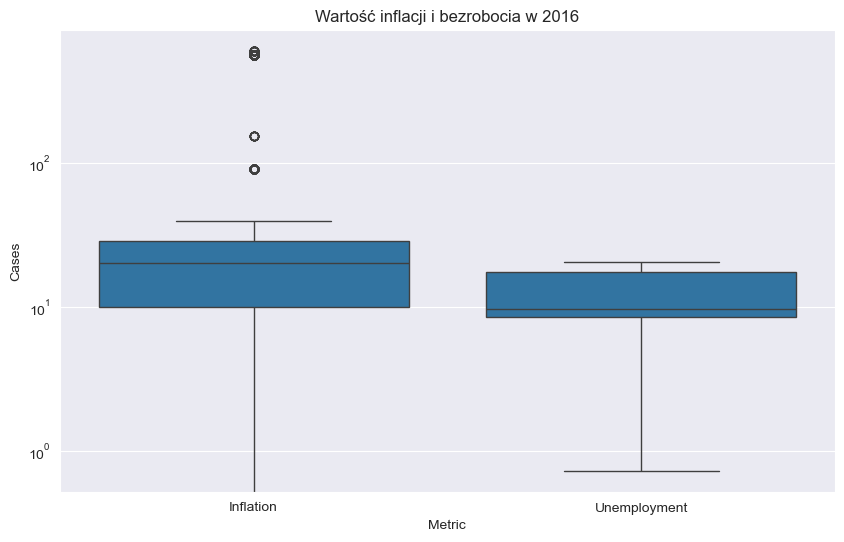

In [33]:
# 1.6 2 dodatkowe kolumny
df_filtered2 = (
    merged_covid_df[merged_covid_df["Year"] == 2016.0]
    .drop_duplicates(subset=["Country_name", "date"])
)

# Konwersja do formatu long (dla jednego wykresu)
df_melted = df_filtered.melt(
    value_vars=["Inflation", "Unemployment"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted,  x="Metric", y="Cases")

# Skala logarytmiczna
plt.yscale("log")

# Opisy
plt.title("Wartość inflacji i bezrobocia w 2016")

# Pokaż wykres
plt.show()

Część 3 (poziom podstawowy) - obliczenia statystyczne
<br> TODO  pozamieniać countries na country code bo zgubiło bułgarię i coś jeszcze

In [73]:
df_3 = pd.read_csv("../wyniki/merge_all_data_from_4.csv")

# Lista wybranych krajów -
countries = ["Portugal", "Lithuania", "Slovakia", "Latvia", "Greece", "Hungary",
                      "Poland", "Croatia" "BGR", "Turkey"]

# Filtrowanie: tylko wybrane kraje i kwiecień 2021
df_filtered3 = df_3[
    (df_3["Country_name"].isin(countries)) &
    (df_3["date"].str.startswith("2021-04"))]

display (df_filtered3)

,Country_name,3_letter_code,population,area_sq_km,population_density,population_urban,gdp_per_capita_usd,date,Total_confirmed_cases,Total_new_vacinations,New_persons_fully_vaccinated,Total_tested
5405,Hungary,HUN,9772756,93030,107.1,6999582.0,16166.0,2021-04-01,8637,90732.0,75988.0,39993
5406,Hungary,HUN,9772756,93030,107.1,6999582.0,16166.0,2021-04-02,6566,79051.0,27807.0,36598
5407,Hungary,HUN,9772756,93030,107.1,6999582.0,16166.0,2021-04-03,3874,76770.0,14115.0,27094
5408,Hungary,HUN,9772756,93030,107.1,6999582.0,16166.0,2021-04-04,1890,50338.0,7895.0,18908
5409,Hungary,HUN,9772756,93030,107.1,6999582.0,16166.0,2021-04-05,1933,69474.0,9874.0,11194
...,...,...,...,...,...,...,...,...,...,...,...,...
28080,Portugal,PRT,10276617,92225,113.0,6753579.0,23364.0,2021-04-02,393,140709.0,86234.0,23135
28081,Portugal,PRT,10276617,92225,113.0,6753579.0,23364.0,2021-04-09,754,259570.0,55268.0,31800
28082,Portugal,PRT,10276617,92225,113.0,6753579.0,23364.0,2021-04-16,720,428785.0,56243.0,31461
28083,Portugal,PRT,10276617,92225,113.0,6753579.0,23364.0,2021-04-23,731,214193.0,141307.0,41386


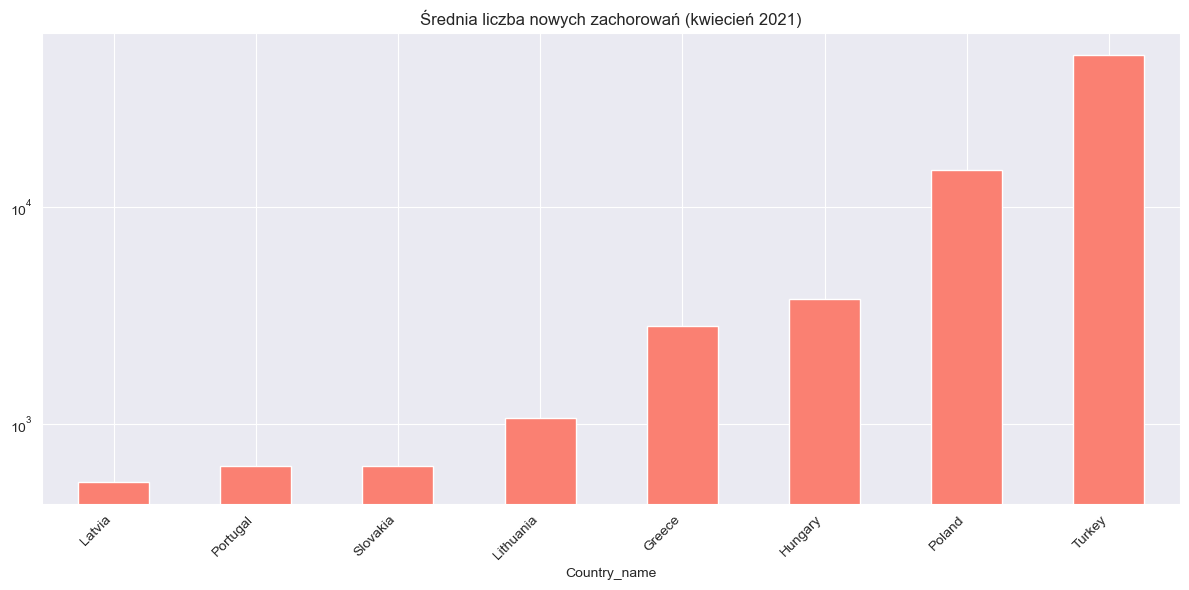

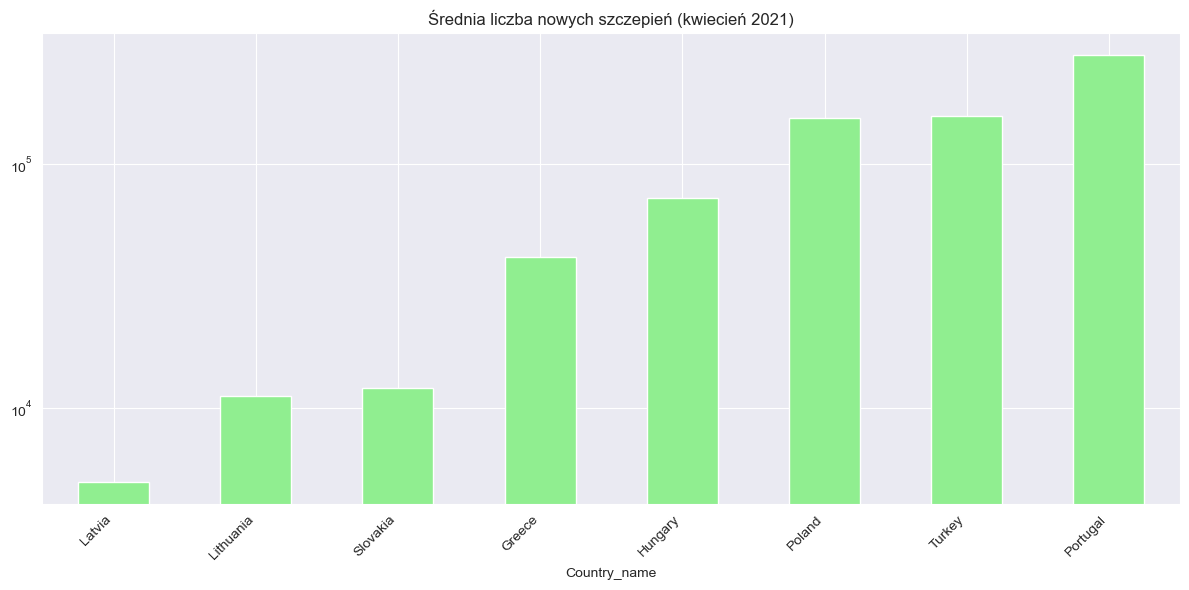

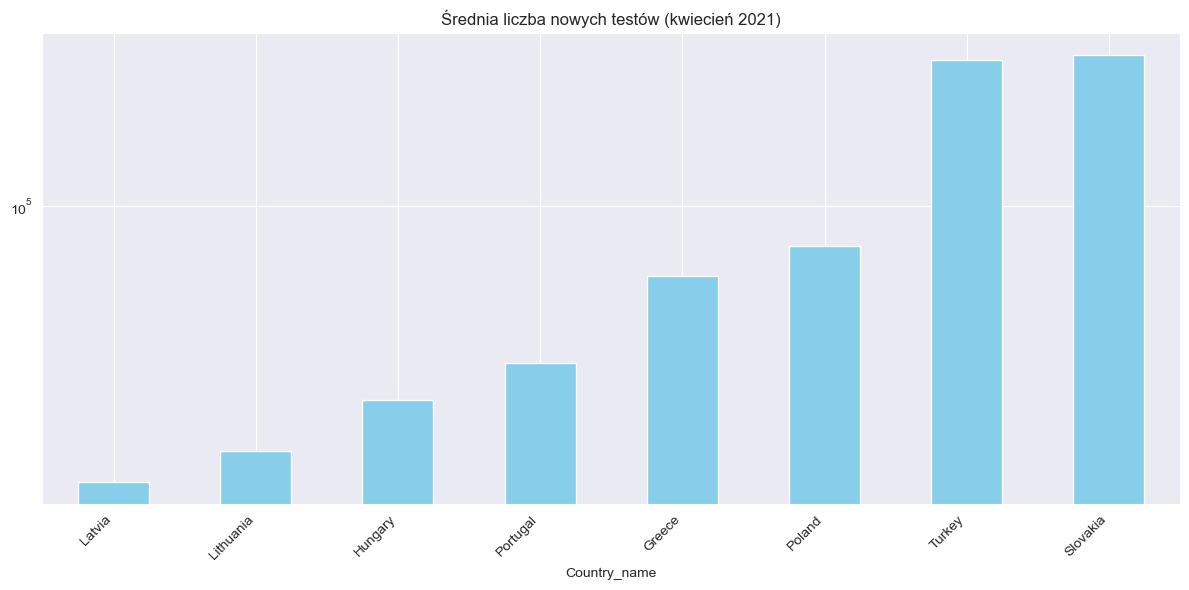

In [74]:
metrics = ["Total_confirmed_cases", "Total_new_vacinations", "Total_tested"]

# 3.1 Średnia liczba nowych zachorowań
mean_confirmed_cases = df_filtered3.groupby("Country_name")["Total_confirmed_cases"].mean().sort_values()
plt.figure(figsize=(12, 6))
mean_confirmed_cases.plot(kind="bar", logy=True, color="salmon")
plt.title("Średnia liczba nowych zachorowań (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.2 Średnia liczba nowych szczepień
mean_vaccinations = df_filtered3.groupby("Country_name")["Total_new_vacinations"].mean().sort_values()
plt.figure(figsize=(12, 6))
mean_vaccinations.plot(kind="bar", logy=True, color="lightgreen")
plt.title("Średnia liczba nowych szczepień (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.3 Średnia liczba nowych testów
mean_tested = df_filtered3.groupby("Country_name")["Total_tested"].mean().sort_values()
plt.figure(figsize=(12, 6))
mean_tested.plot(kind="bar", logy=True, color="skyblue")
plt.title("Średnia liczba nowych testów (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Uwaga - dane dla Chorwacji pochodzą tylko z 5 dni, a dla Bułgarii z 15. Reszta państw notowała w miarę dobrze z 25-31 dni
